# Interfacing R from Python

While Python is quite versatile language that makes solving problems very simple, the language R has its own strengths. It has been very popular in the academic circles and many of the bioinformatics algorithms often gets released as R packages. Often, the only possible way solve a particular problem effectively is using R.

It is pragmatic to use the right tool for the right job. In this session, we'll see how to use R from Python. We'll see two different approaches - using R from jupyter notebooks along with Python and using R in scripts and streamlit applications.

## The `rpy2` package

The `rpy2` package in Python provides a way to execute R from python and it also has good support for jupyter notebooks.

### Using R in the notebook

Import `rpy2` package.

In [2]:
import rpy2

And load rpy2 jupyter extension.

In [3]:
%load_ext rpy2.ipython

Now we can run R code and even plot graphs.

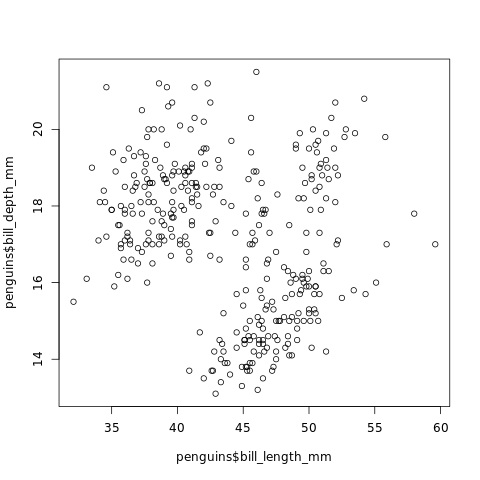

In [4]:
%%R 
library(palmerpenguins)

# Print the first 6 rows
head(penguins, 6)

plot(penguins$bill_length_mm, penguins$bill_depth_mm)

You can even use the familiar `ggplot2` library.

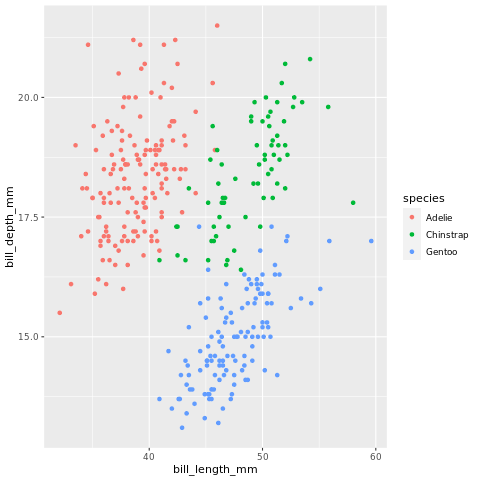

In [5]:
%%R 

# Whatever we have run earlier in R will still be available here.

library(ggplot2)

ggplot(penguins, aes(bill_length_mm, bill_depth_mm, colour = species)) + 
  geom_point()

## Passing values between Python and R

In [7]:
import pandas as pd

Define two of values in Python.

In [8]:
x = 10
y = 20

Add add them in R.

In [9]:
%%R -i x -i y

x + y

[1] 30


It is even possible to access the value of a variable define in R from Python, but we'll look into into it later.

Interesting part of this approach is that we can even pass dataframes into R.

In [10]:
df = pd.read_csv("../shared/un-min.csv")

In [11]:
df.head()

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
0,Afghanistan,Asia,45.0,46.0,154,2848
1,Albania,Europe,68.0,74.0,32,863
2,Algeria,Africa,67.5,70.3,44,1531
3,Angola,Africa,44.9,48.1,124,355
4,Argentina,America,69.6,76.8,22,8055


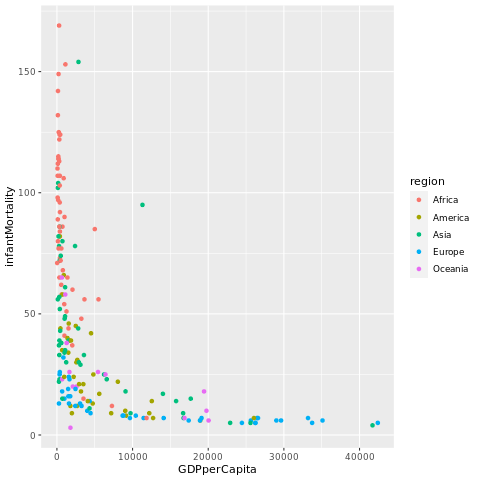

In [12]:
%%R -i df

library(ggplot2)

ggplot(df, aes(GDPperCapita, infantMortality, colour = region)) + 
  geom_point()

**Question:** Can we read dataframe in R and get it to Python and plot?

An easy way is to write the dataframe in R to a file and read it in python. We'll look into another approach in a later section.

In [14]:
%%R

data(mtcars)
head(mtcars)

write.csv(mtcars, "mtcars.csv")

In [16]:
!ls -l mtcars.csv

-rw-r--r-- 1 anand anand 1783 Jun  3 03:59 mtcars.csv


In [17]:
df = pd.read_csv("mtcars.csv")

In [18]:
df.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


<Axes: xlabel='mpg', ylabel='hp'>

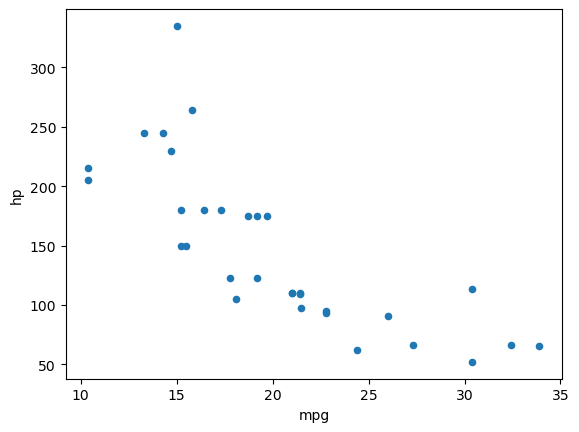

In [21]:
df.plot(kind="scatter", x="mpg", y="hp")

**Problem:** Plot a graph of `lifeMale` vs. `lifeFemale`, color by region and size by th GDP using ggplot2 in R.

**Problem:** Read iris dataset from `../shared/iris.csv` in Python and plot a scatter plot on `SepalLength` vs. `SepalWidth` and color by `Name` using R.

## Invoking R programatically

Invoking R programatically can be done using the rpy2 package without using the `%%R` magic method.

The `rpy2` module allows passing inputs to R and read the results back. While there may be issues with convertion of types between python and R, it will be simpler if we stick to primitive and well known types.

To make things simple for you, I have created a function `rexec`.

In [49]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

def rexec(code, **params):
    """Script to run R code passing some inputs to it.

        >>> rexec("print(x+y)", x=10, y=20)
        [1] 30

    If you would like to get back some result from R, assign that 
    to variable result.

        >>> rexec("result <- x + y", x=10, y=20)
        array([30], dtype=int32)
    """
    # rpy2 has some multi-threading issues and this is the recommended way to convert python objects to R
    # See https://github.com/rpy2/rpy2/issues/978
    with localconverter(robjects.default_converter + pandas2ri.converter) as cv:
        robjects.globalenv['result'] = False
        for k, v in params.items():
            robjects.globalenv[k] = cv.py2rpy(v)
        robjects.r(code)

        result = robjects.r.get("result")
        if result is not None:
            return cv.rpy2py(result)


In [24]:
rexec("print(x+y)", x=10, y=20)

[1] 30


0


In [25]:
z = rexec("result <- x+y", x=10, y=20)

In [26]:
z

array([30], dtype=int32)

In [27]:
z[0]

30

### Ploting and Saving Graphs

Now, let us look at running a complete R script from python by passing inputs and outputs only through files.

It reads the input from `../shared/un-min.csv` and write the graph as image to `rplot.png`.

In [29]:
df = pd.read_csv("../shared/un-min.csv")

In [30]:
df.head()

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
0,Afghanistan,Asia,45.0,46.0,154,2848
1,Albania,Europe,68.0,74.0,32,863
2,Algeria,Africa,67.5,70.3,44,1531
3,Angola,Africa,44.9,48.1,124,355
4,Argentina,America,69.6,76.8,22,8055


In [37]:
code = """
library(ggplot2)

ggplot(df, aes(GDPperCapita, lifeFemale, colour = region)) + 
  geom_point()
  
ggsave(filename = image_path) 
"""

In [38]:
rexec(code, df=df, image_path="rplot.png")

Saving 7 x 7 in image


0


In [39]:
!ls -l *.png

-rw-r--r-- 1 anand anand 136075 Jun  3 04:13 rplot.png


In [40]:
from IPython.display import Image

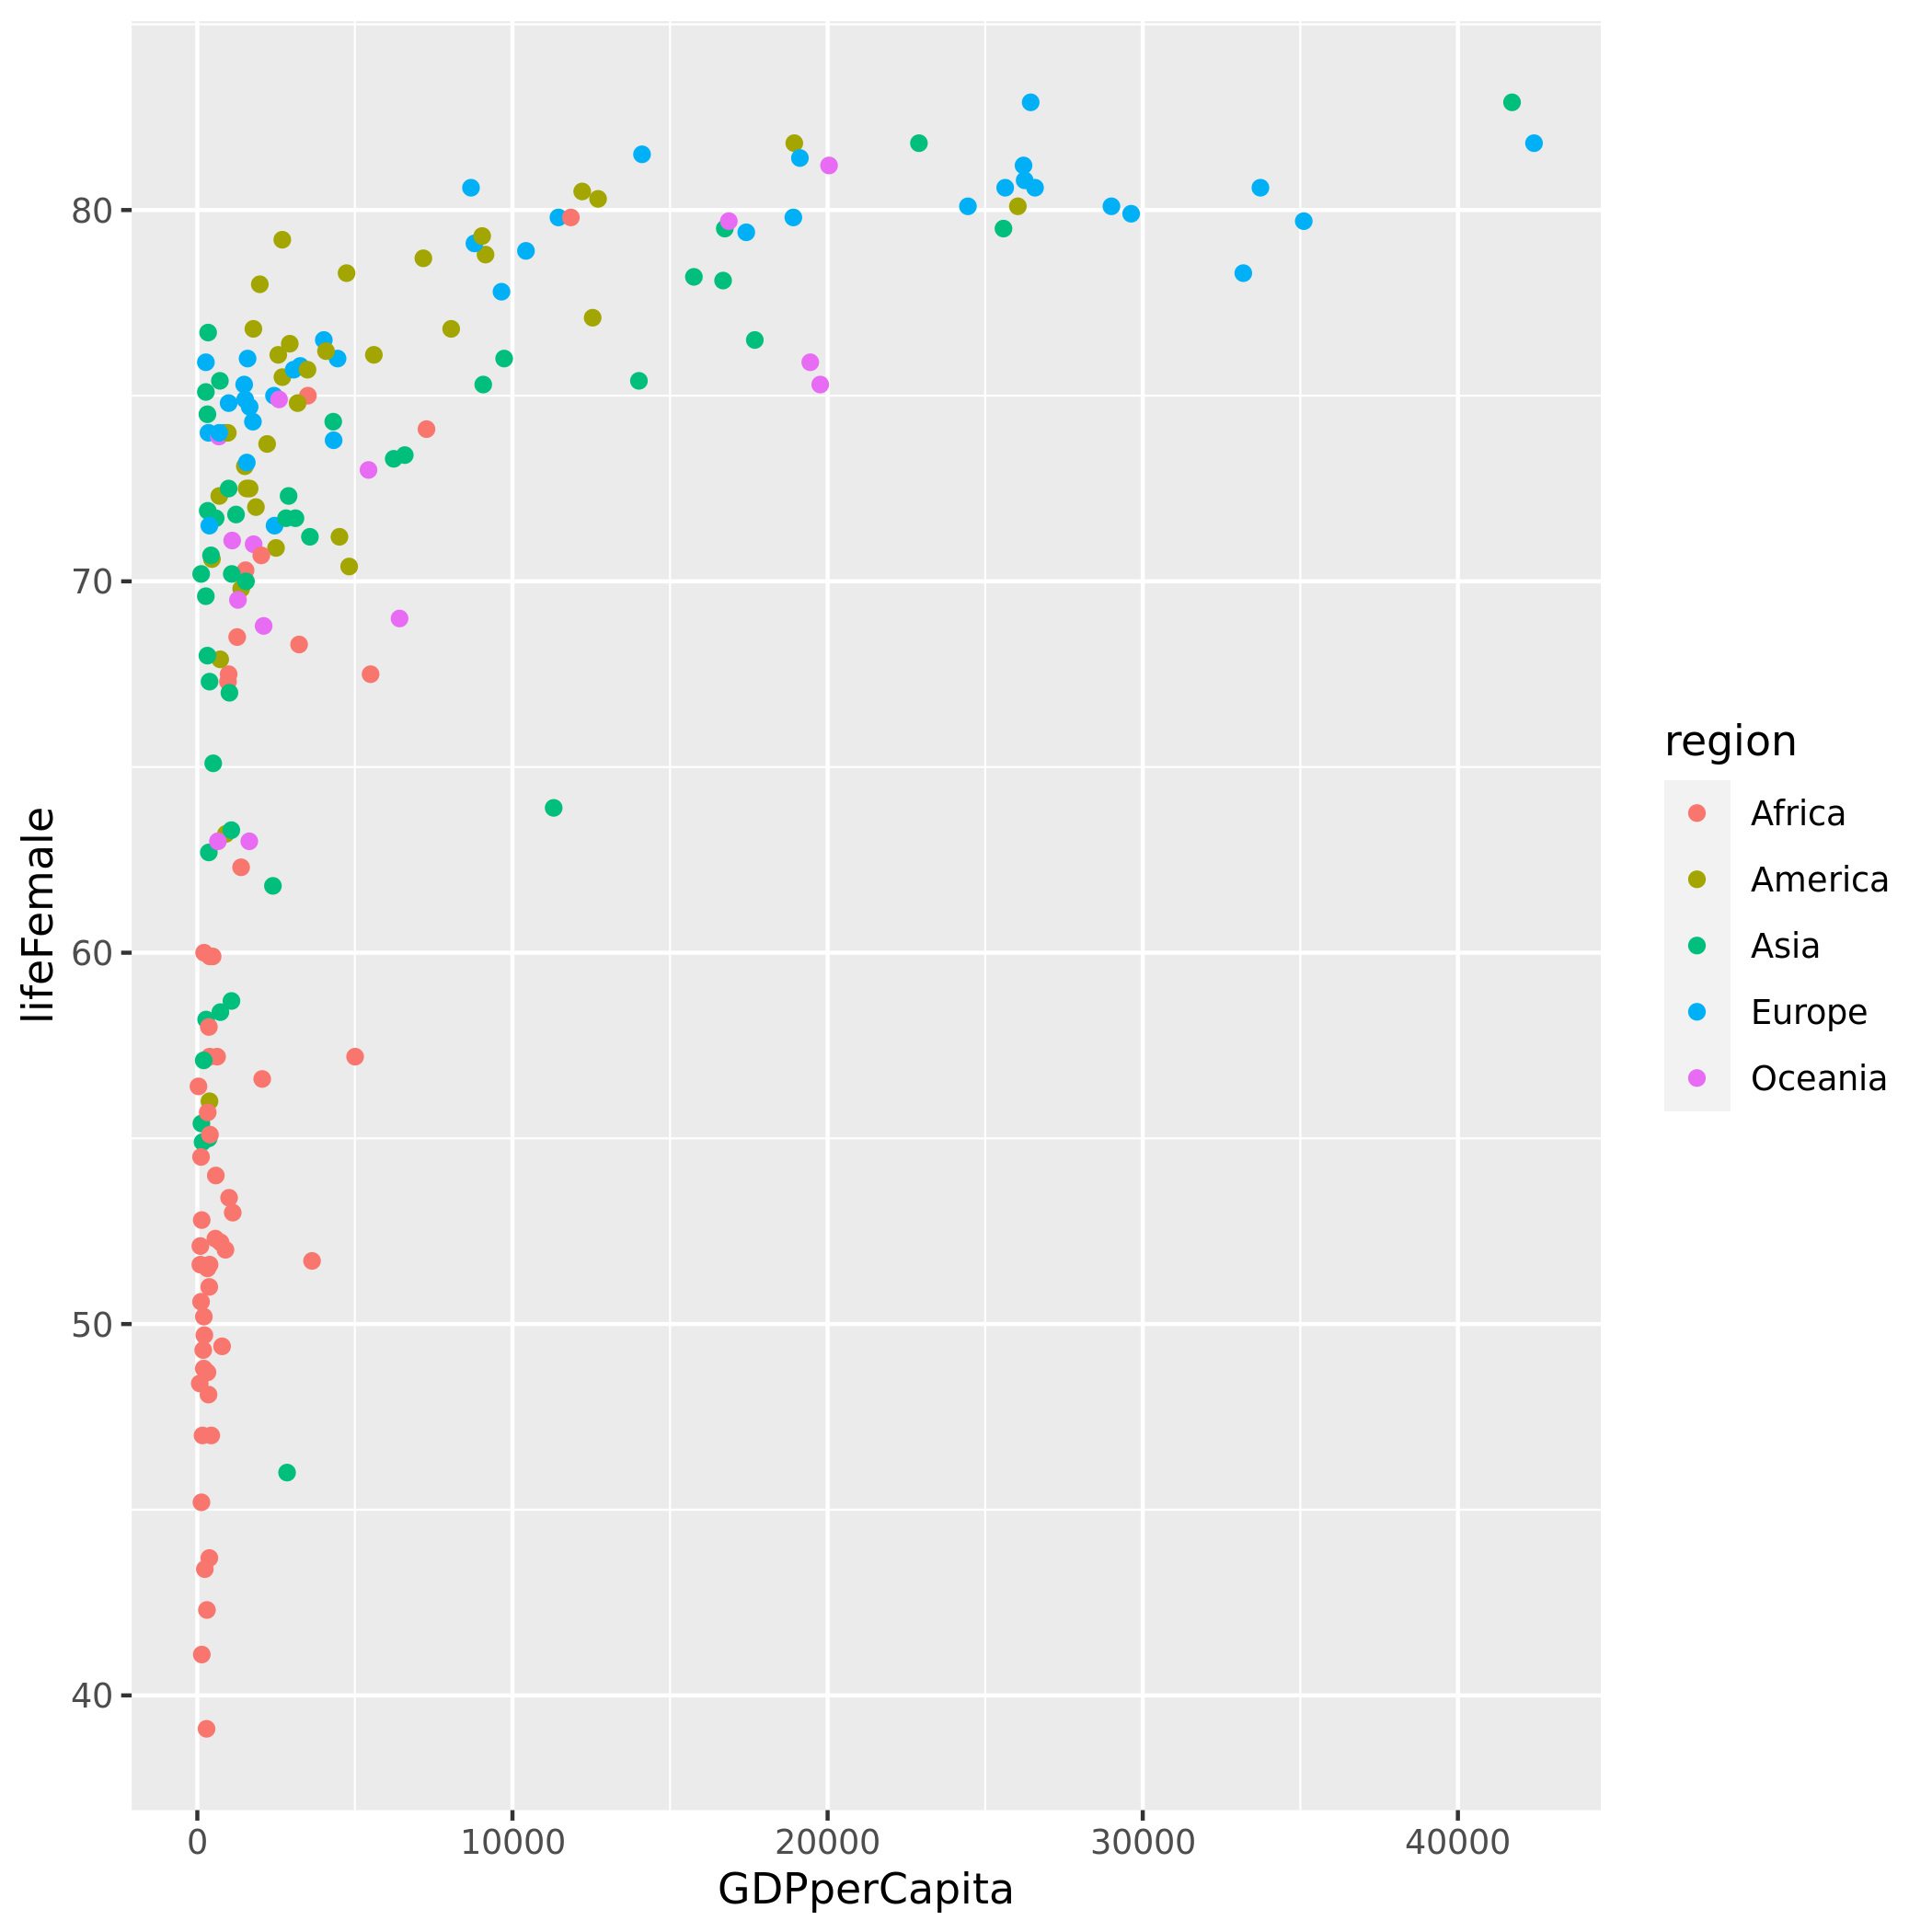

In [41]:
Image(filename="rplot.png")

**Q:** Can we do some analysis in R and get the results back in Python for plotting?

Let's take iris dataset, pass it to R for aggregation, get the result back to Python and plot them.

In [42]:
df.head()

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
0,Afghanistan,Asia,45.0,46.0,154,2848
1,Albania,Europe,68.0,74.0,32,863
2,Algeria,Africa,67.5,70.3,44,1531
3,Angola,Africa,44.9,48.1,124,355
4,Argentina,America,69.6,76.8,22,8055


In [43]:
df.set_index("country", inplace=True)

In [44]:
df.head()

,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
country,,,,,
Afghanistan,Asia,45.0,46.0,154,2848
Albania,Europe,68.0,74.0,32,863
Algeria,Africa,67.5,70.3,44,1531
Angola,Africa,44.9,48.1,124,355
Argentina,America,69.6,76.8,22,8055


In [47]:
code = """
df2 <- aggregate(. ~ region, df, mean)
result <- df2
"""

In [50]:
rexec(code, df=df)

,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
1,Africa,52.052830,55.286792,86.320755,1217.641509
2,America,69.082857,74.474286,26.657143,5080.085714
3,Asia,65.373913,69.439130,43.782609,5453.195652
4,Europe,70.362500,77.545000,11.575000,12860.050000
5,Oceania,67.464286,72.092857,24.642857,7131.785714
